In [ ]:
pip install tensorflow

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import models,layers
from tensorflow.keras.utils import to_categorical






In [5]:
# Path to the folder containing the numbered images
image_folder = r"D:\Lectures\Senior-2\Deep Learning\Project\images\images"

# Path to the CSV file
csv_file_path = r"C:\Users\sheha\OneDrive\Desktop\train.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path)

# Function to load and parse images
def load_images_and_labels(image_folder, df, target_size=(1620, 1050)):
    data = []
    labels = []

    for index, row in df.iterrows():
        image_id = row['id']
        species = row['species']

        # Construct the image file path based on the ID
        image_path = os.path.join(image_folder, f"{image_id}.jpg")

        # Load the image using OpenCV in grayscale mode
        #image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


        # Resize the image to the target size with replicated padding
        height, width = image.shape
        new_height, new_width = target_size

        # Calculate padding
        pad_height = max(0, (new_height - height) // 2)
        pad_width = max(0, (new_width - width) // 2)

        # Replicate padding
        image = cv2.copyMakeBorder(image, pad_height, pad_height, pad_width, pad_width, cv2.BORDER_REPLICATE)

        # Resize the image to the target size
        image = cv2.resize(image, (new_width, new_height))

        # Convert OpenCV image to TensorFlow tensor
        numpy_array = np.array(image)

         # Append the image and label to the lists
        data.append(numpy_array)
        labels.append(species)

    return data,labels

# Load images and labels
images,labels = load_images_and_labels(image_folder, df, target_size=(1620, 1050))



In [6]:
updated_labels = np.array(labels)
updated_images= np.array(images)

In [7]:
print(updated_images.shape)
print(updated_labels.shape)

(990, 1620, 1050)
(990,)


In [8]:
updated_images= updated_images.reshape(len(updated_images),1620,1050,1)
updated_labels= updated_labels.reshape(len(updated_labels),1)

In [9]:
print(updated_images.shape)
print(updated_labels.shape)

(990, 1620, 1050, 1)
(990, 1)


In [10]:
LabelEncoder  = preprocessing.LabelEncoder()
LabelEncoder.fit(updated_labels)
num_labels = LabelEncoder.transform(updated_labels)



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
# Create a DataFrame
df_result = pd.DataFrame({'images': updated_images, 'labels': num_labels})

# Save the DataFrame to a CSV file
output_csv_path = r"E:\Semester 9\Deep Learning\Project\dataset.csv"
df_result.to_csv(output_csv_path, index=False)

In [68]:
network = models.Sequential()

# First Convolutional layer with (3,3) matrix size, same padding refers to add additional columns or rows to align
# with the filter and a maxpooling layers which takes maximum value in the (3,3) pixel value matrix.
network.add(layers.Conv2D(10,(3,3), padding='valid', activation='relu', input_shape = (1620,1050,1)))
network.add(layers.MaxPool2D((3,3)))

# Second convolutional layer same as above but this one produces 16 feature maps unlike 10 above.
network.add(layers.Conv2D(16,(3,3), padding='valid', activation='relu'))
network.add(layers.MaxPool2D((3,3)))


# Third convolutional layer same as above but this one produces 128 feature maps unlike 256 above.
network.add(layers.Conv2D(16,(3,3), padding='valid', activation='relu'))
network.add(layers.MaxPool2D((3,3)))

# Flatten layer
network.add(layers.Flatten())



# Dense layer of 64 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(64, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Dropout layer of 20%
network.add(layers.Dropout(0.2))

# Dense Layer of 64 neurons with L2 regularization and ReLU activation function
network.add(layers.Dense(64, kernel_regularizer = regularizers.l2(0.01), activation='relu'))

# Final Dense Layer with number of neurons same as number of classes of classification and 'softmax' as the
# activation function
# softmax is useful because it converts the output layer into what is essentially a probability distribution.
network.add(layers.Dense(99, activation='softmax'))

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(updated_images, num_labels, test_size=0.2, random_state=5, shuffle=True)


In [70]:
Y_train_one_hot = to_categorical(Y_train, num_classes = 99)

In [71]:
Y_test_one_hot = to_categorical(Y_test, num_classes = 99)

50/50 [==============================] - 46s 914ms/step - loss: 6.7920 - accuracy: 0.0505


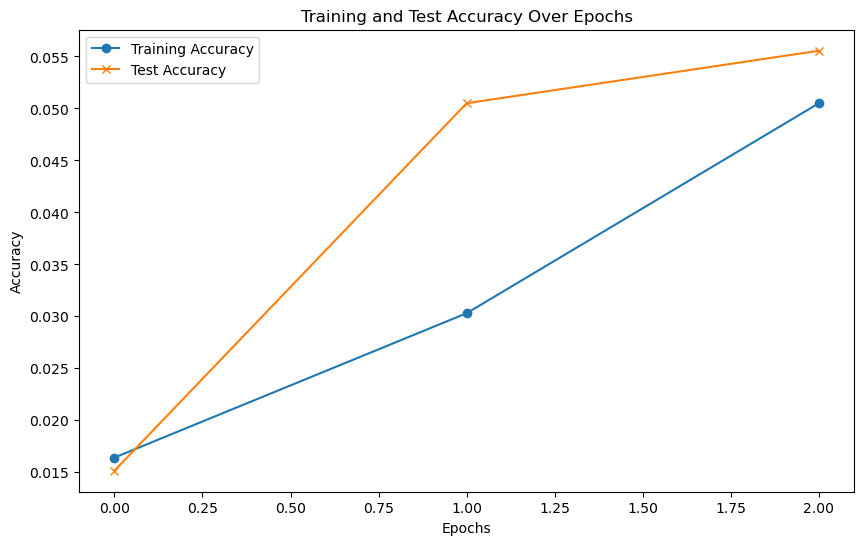

In [72]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

# Compile the model (you might have already done this before training)
optimizer = SGD(learning_rate=0.01)
network.compile(optimizer=optimizer, loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Lists to store training and test accuracy for each epoch
train_accuracy_history = []
test_accuracy_history = []

# Training loop
epochs = 3
for epoch in range(epochs):
    # Train the model on the training set
    train_results = network.fit(x=X_train, y=Y_train_one_hot, batch_size=16, epochs=1, verbose=1)

    # Record training accuracy for this epoch
    train_accuracy_history.append(train_results.history['accuracy'][0])

    # Evaluate the model on the test set
    test_results = network.evaluate(X_test, Y_test_one_hot, verbose=0)

    # Record test accuracy for this epoch
    test_accuracy_history.append(test_results[1])

# Plotting the accuracy over epochs
plt.figure(figsize=(10, 6))

plt.plot(train_accuracy_history, label='Training Accuracy', marker='o')
plt.plot(test_accuracy_history, label='Test Accuracy', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Epochs')
plt.legend()
plt.show()